In [3]:
!pip install -q rouge_score transformers bert_score

In [11]:
import torch
from typing import List, Dict
from rouge_score import rouge_scorer, scoring
import bert_score
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt


START_POPULATION='<pop>'
END_POPULATION='</pop>'
START_INTERVENTION='<int>'
END_INTERVENTION='</int>'
START_OUTCOME='<out>'
END_OUTCOME='</out>'
START_BACKGROUND = '<background>'
END_BACKGROUND = '</background>'
START_REFERENCE = '<ref>'
END_REFERENCE = '</ref>'
START_EVIDENCE = '<evidence>'
END_EVIDENCE = '</evidence>'
SEP_TOKEN = '<sep>'
EXTRA_TOKENS = [
    START_BACKGROUND,
    END_BACKGROUND,
    START_REFERENCE,
    END_REFERENCE,
    SEP_TOKEN,
    START_POPULATION,
    END_POPULATION,
    START_INTERVENTION,
    END_INTERVENTION,
    START_OUTCOME,
    END_OUTCOME,
    START_EVIDENCE,
    END_EVIDENCE,
]


def rouge_scores(
    preds: List[List[torch.Tensor]], targets: List[List[torch.Tensor]],
    tokenizer, use_stemmer=False, use_aggregator=False
):
    # largely copied from https://github.com/huggingface/nlp/blob/master/metrics/rouge/rouge.py#L84
    # and from https://github.com/allenai/ms2/blob/a03ab009e00c5e412b4c55f6ec4f9b49c2d8a7f6/ms2/models/utils.py
    rouge_types = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
    scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer)
    refs, hyps = [], []
    for p, t in zip(preds, targets):
        assert len(p) == len(t)
        refs.extend(p)
        hyps.extend(t)

    if use_aggregator:
        aggregator = scoring.BootstrapAggregator()
        scores = None
    else:
        aggregator = None
        scores = []

    for ref, pred in zip(refs, hyps):
        if isinstance(ref, torch.Tensor):
            ref = tokenizer.decode(ref).lower()
        if isinstance(pred, torch.Tensor):
            pred = tokenizer.decode(pred).lower()
        score = scorer.score(ref, pred)
        if use_aggregator:
            aggregator.add_scores(score)
        else:
            scores.append(score)

    if use_aggregator:
        result = aggregator.aggregate()
    else:
        result = {}
        for key in scores[0]:
            result[key] = list(score[key] for score in scores)

    return result


def get_tokenizer(tokenizer_type: str):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_type, additional_special_tokens=EXTRA_TOKENS)
    return tokenizer


def calculate_rouge(targets: Dict[str, Dict], generated: Dict[str, str]) -> Dict:
    """
    Calculate ROUGE scores
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :return: dict of ROUGE scores (rouge1, rouge2, rougeL, rougeLsum)
    """
    # copied from https://github.com/allenai/mslr-shared-task/blob/c2218c1a440cf5172d784065b48af2d6c5c50f9a/evaluator/evaluator.py
    print("Computing ROUGE scores...")
    docids = list(targets.keys())
    target_texts = [[targets[docid]['target']] for docid in docids]
    generated_texts = [[generated.get(docid, '')] for docid in docids]

    # rouge scoring
    tokenizer = get_tokenizer('facebook/bart-base')
    rouge_results = rouge_scores(generated_texts, target_texts, tokenizer, use_aggregator=True)
    return rouge_results


def calculate_mid_rouge(targets: Dict[str, Dict], generated: Dict[str, str]) -> Dict:
    """
    Calculate ROUGE scores but only return mid fmeasure.
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :return: dict of ROUGE scores (rouge1, rouge2, rougeL, rougeLsum)
    """
    results = calculate_rouge(targets, generated)
    return {
        "rouge": results,
        "rouge1": results["rouge1"].mid.fmeasure,
        "rouge2": results["rouge2"].mid.fmeasure,
        "rougeL": results["rougeL"].mid.fmeasure,
        "rougeLsum": results["rougeLsum"].mid.fmeasure,
    }


def calculate_bertscore(
    targets: Dict[str, Dict], generated: Dict[str, str], model_type="roberta-large"
) -> Dict:
    """
    Calculate BERTscore
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :param model_type: model type for BERTscore. Choose from many choices (look
        up bert-score github). Note that MSLR/MS2 uses roberta-large in default
        args, but https://huggingface.co/allenai/led-base-16384-ms2 uses
        `microsoft/deberta-xlarge-mnli`. Note that `bert-score`
        recommends `microsoft/deberta-xlarge-mnli` as the one with best
        correlation with human judgement. Details here:
        https://huggingface.co/microsoft/deberta-xlarge-mnli
    :return: dict of BERTscore results (bs_ps, bs_rs, bs_fs) (precision, recall, f1)
    """
    # copied from https://github.com/allenai/mslr-shared-task/blob/c2218c1a440cf5172d784065b48af2d6c5c50f9a/evaluator/evaluator.py
    # original bert score: https://github.com/Tiiiger/bert_score
    print("Computing BERTscore...")
    docids = list(targets.keys())
    target_texts = [targets[docid]['target'] for docid in docids]
    generated_texts = [generated.get(docid, '') for docid in docids]

    # BERTscore
    bs_ps, bs_rs, bs_fs = bert_score.score(generated_texts, target_texts, model_type=model_type)
    return {
        "bs_ps": bs_ps,
        "bs_rs": bs_rs,
        "bs_fs": bs_fs
    }


def calculate_mean_bertscore(
    targets: Dict[str, Dict], generated: Dict[str, str], model_type="roberta-large"
) -> Dict:
    """
    Calculate mean BERTscore
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :param model_type: model type for BERTscore.
    :return: dict of mean BERTscore results (bs_ps, bs_rs, bs_fs) (precision, recall, f1)
    """
    individual_results = calculate_bertscore(targets, generated, model_type=model_type)

    results = {
        "bertscore_avg_p": torch.mean(individual_results["bs_ps"]).item(),
        "bertscore_avg_r": torch.mean(individual_results["bs_rs"]).item(),
        "bertscore_avg_f": torch.mean(individual_results["bs_fs"]).item(),
        "bertscore_std_p": torch.std(individual_results["bs_ps"]).item(),
        "bertscore_std_r": torch.std(individual_results["bs_rs"]).item(),
        "bertscore_std_f": torch.std(individual_results["bs_fs"]).item(),
    }
    return results


# pull in original validation data from huggingface datasets
dataset = load_dataset("allenai/mslr2022", "ms2", split="validation")  # takes 9 mins
display(dataset)

# organize target data into dicts for rouge and bertscore
targets = {row['review_id']: row for row in dataset}

In [13]:
# Test with some toy examples

targets_toy = {
    "doc1": {"target": "The quick brown fox jumps over the lazy dog"},
    "doc2": {"target": "fruit flies like a banana"},
    "doc3": {"target": "fruit flies like a banana"},
    "doc4": {"target": "fruit flies like a banana"},
    "doc5": {"target": "everything is chaotic"},
    "doc6": {"target": "The quick brown fox jumps over the lazy dog"},
}

generated_toy = {
    "doc1": "A lazy dog is under a hopping speedy fox",  # synonym
    "doc2": "some insects are attracted to a yellow fruit",  # one interpretation
    "doc3": "most fruits have the aerodynamic properties of a banana",  # another interpretation
    "doc4": "nothing makes sense",  # completely irrelevant
    "doc5": "nothing makes sense",  # synonym
    "doc6": "The quick brown fox jumps over the lazy dog",  # perfect/identical
}

rouge_results = calculate_rouge(targets_toy, generated_toy)
display(rouge_results)

bertscore_results = calculate_bertscore(targets_toy, generated_toy, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge1': AggregateScore(low=Score(precision=0.12222222222222223, recall=0.0787037037037037, fmeasure=0.0989010989010989), mid=Score(precision=0.35555555555555557, recall=0.28703703703703703, fmeasure=0.31684981684981683), high=Score(precision=0.6333333333333333, recall=0.5972222222222222, fmeasure=0.6068376068376068)),
 'rouge2': AggregateScore(low=Score(precision=0.020833333333333332, recall=0.020833333333333332, fmeasure=0.020833333333333332), mid=Score(precision=0.20833333333333334, recall=0.20833333333333334, fmeasure=0.20833333333333334), high=Score(precision=0.5625, recall=0.5416666666666666, fmeasure=0.548611111111111)),
 'rougeL': AggregateScore(low=Score(precision=0.07407407407407407, recall=0.05787037037037037, fmeasure=0.07326007326007326), mid=Score(precision=0.30370370370370364, recall=0.26157407407407407, fmeasure=0.2716727716727717), high=Score(precision=0.5711111111111105, recall=0.5578703703703703, fmeasure=0.5626780626780626)),
 'rougeLsum': AggregateScore(low=Score

Computing BERTscore...


{'bs_ps': tensor([0.7381, 0.5301, 0.5480, 0.3825, 0.6740, 1.0000]),
 'bs_rs': tensor([0.7276, 0.5883, 0.6598, 0.4499, 0.6900, 1.0000]),
 'bs_fs': tensor([0.7328, 0.5577, 0.5987, 0.4135, 0.6819, 1.0000])}

In [33]:
# Test with some toy examples

targets_x_sample = {
    "28514886": {
        "target": "Current evidence from systematic review and meta- analysis revealed that probiotics are the most promising intervention in reduction of the incidence of NEC in VLBW neonates . As per the evidence , prebiotics modulate the composition of human intestine microflora to the benefit of the host by suppression of colonization of harmful microorganism and /or the stimulation of bifidobacterial growth , decreased stool viscosity , reduced gastrointestinal transit time , and better feed tolerance .",
        "background": targets["28514886"]["background"],
    },
    "18842808": {
        "target": "The use of glucomannan did not appear to significantly alter any other study endpoints . Pediatric patients , patients receiving dietary modification , and patients with impaired glucose metabolism did not benefit from glucomannan to the same degree . Glucomannan appears to beneficially affect total cholesterol , LDL cholesterol , triglycerides , body weight , and FBG , but not HDL cholesterol or BP",
        "background": targets["18842808"]["background"],
    },
}

generated_2_sample = {
    "28514886": "Retrieve concise conclusion without background: BACKGROUND : Necrotizing enterocolitis ( NEC ) is one of the most destructive diseases associated with the intestine. We aim to determine the effect of a preterm formula containing partially hydrolyzed whey protein, modified vegetable oil with a high & bgr;-palmitic acid content, on the intestinal flora. We hypothesized that enteral supplementation of a prebiotic mixture consisting of neutral oligosaccharides ( (SC)GOS/(LC)FOS ) and acidic oligosaccharides ( AOS ) on intestinal permeability. In a double-blind trial 20 preterm infants ( gestational age 27 ( 24 - 31 ) weeks, postnatal age 42 ( 11 - 84 ) days ), and weight at study entry 1570 ( 1080 - 2300 ) g were enrolled. The infants were randomized to receive either a formula with 8 g/L of either GOS/LCFOS ( 1.5 or 3.0 g/kg ). The stool specimens were quantitatively cultured weekly for the number of bifidobacteria, gastric residue, bowel habits, and feeding tolerance.  Clinical examination including anthropometric measurements, microbiological analysis of fecal sample s, and blood leukocyte population analysis were performed at birth and 6 and 10 weeks... The results showed that the incidence of NEC, the group fed the oligosaccharide supplemented formula increased to the upper range of infant growth, and the placebo group. The incidence of > or = 1 serious infection, as measured by extrusion force ( P=0.006 ), was not significantly different in the supplemented group ( P = 0.056 )..  The intestinal microbiota of infants who received a st and ard formula seems to resemble a more mature gut flora, while the 0.8 g/dL group, 9.7 - 14 % of these neonates.. Conclusion : Neonatal enteric NEC. The intestinal flora of preterm neonates was not different between the 2 groups. and/.}).",
    "18842808": "Retrieve concise conclusion without background: BACKGROUND The purpose of this study was to evaluate the effectiveness of the hydrosoluble fiber glucomannan to a Step-One-Diet in mildly hypercholesterolemic type II diabetic and non-diabetic subjects and to compare the response of these two subject groups to the treatments. MATERIAL / METHODS One hundred and seventy six men and women were included to receive either active fiber substance or placebo in r and omized placebo-controlled studies. The subjects were encouraged not to change their ordinary diets or general lifestyle during the investigation. RESULTS : After a three-days food recall, a balanced diet with adequate caloric intake was provided to all obese children. In all patients before and 2 - 4 months after the intervention, the plasma lipids ( weight, height, weight excess ) and laboratory data ( serum levels of cholesterol, HDL, triglycerides, glucose, fructosamine, glycosylated hemoglobin, RBC, WBC, hemoglobin, iron, calcium, Cu and Zn ) have been determined. Excess weight and triglycerids levels were significantly decreased in treated obese patients than in obese controls 4 months later. Both groups experienced decreases in ( P < 0.01 ) body weight, percent body fat, systolic blood pressure, waist circumference, and plasma glucose levels. After 12 weeks, HDL-C and TAG improved significantly in the fiber ( 10 % and -34 % ) and placebo ( 14 %, -43 % ) groups. The results of lipid profiles did not differ between subject groups. Overall plasma lathosterol concentrations, as well as FBG, and other lipids were lowered ( P<0.05 ). The study to perform a meta- analysis of r, omized controlled trials of glucarannan on plasma lipid, FBG.. and).-..",
}

rouge_results = calculate_mid_rouge(targets_2_sample, generated_2_sample)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets_2_sample, generated_2_sample, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4727272727272727, recall=0.09961685823754789, fmeasure=0.16455696202531644), mid=Score(precision=0.4754940711462451, recall=0.10959103781442611, fmeasure=0.1779306549257017), high=Score(precision=0.4782608695652174, recall=0.11956521739130435, fmeasure=0.19130434782608696)),
  'rouge2': AggregateScore(low=Score(precision=0.08823529411764706, recall=0.019230769230769232, fmeasure=0.03184713375796178), mid=Score(precision=0.09041394335511982, recall=0.020524475524475526, fmeasure=0.033416278249243286), high=Score(precision=0.09259259259259259, recall=0.02181818181818182, fmeasure=0.03498542274052478)),
  'rougeL': AggregateScore(low=Score(precision=0.2727272727272727, recall=0.05747126436781609, fmeasure=0.0949367088607595), mid=Score(precision=0.2812911725955204, recall=0.06496751624187906, fmeasure=0.10543936892313338), high=Score(precision=0.2898550724637681, recall=0.07246376811594203, fmeasure=0.11594202898550726)),
  'rougeL

Computing BERTscore...


{'bertscore_avg_p': 0.47608551383018494,
 'bertscore_avg_r': 0.6032038927078247,
 'bertscore_avg_f': 0.5320615768432617,
 'bertscore_std_p': 0.006571114994585514,
 'bertscore_std_r': 0.014886646531522274,
 'bertscore_std_f': 0.0016888664104044437}

## Evaluating on model outputs

### BioBART

In [79]:
# Open results from BioBART on validation set
df_biobart = pd.read_csv("pretrained_no_finetune/biobart/biobart_validation.csv")
# review_id is the docid and should be a string
df_biobart['review_id'] = df_biobart['review_id'].astype(str)
display(df_biobart.head())

# organize into dicts for rouge and bertscore
generated_biobart = {row['review_id']: row['candidate'] for _, row in df_biobart.iterrows()}

# check to see if all docids are present and unique
assert set(generated_biobart.keys()) == set(targets.keys())
assert len(generated_biobart) == len(targets)

,review_id,candidate
0,26762372,Background : The aim of the present study was...
1,28723736,BACKGROUND Surgical site infections ( SSIs ) ...
2,22002191,BACKGROUND AND PURPOSE : The purpose of this ...
3,31921439,Background : Several established tools are av...
4,30301735,Background Topical glyceryl trinitrate ( GTN ...


<Axes: >

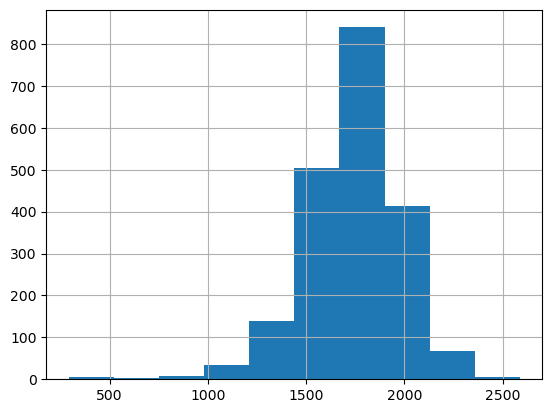

In [8]:
df_biobart.candidate.str.len().hist()

In [9]:
# SMALL SUBSET DATASET - calculate rouge and bertscore for only 10 docs

subset_review_ids = list(generated_biobart.keys())[:10]
targets_subset = {docid: targets[docid] for docid in subset_review_ids}
generated_subset = {docid: generated_biobart[docid] for docid in subset_review_ids}

rouge_results = calculate_mid_rouge(targets_subset, generated_subset)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets_subset, generated_subset, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4085764548117969, recall=0.09217051335154197, fmeasure=0.1448897839623271), mid=Score(precision=0.46691416592132295, recall=0.1346856479283819, fmeasure=0.19092749741701748), high=Score(precision=0.5227113929191609, recall=0.18335498949362816, fmeasure=0.24417392291854567)),
  'rouge2': AggregateScore(low=Score(precision=0.07378749078582353, recall=0.019862255033613725, fmeasure=0.030216589670523743), mid=Score(precision=0.1241565192861693, recall=0.029366603129565398, fmeasure=0.042641450275991935), high=Score(precision=0.17737006675077563, recall=0.04004910719325335, fmeasure=0.05588984314531449)),
  'rougeL': AggregateScore(low=Score(precision=0.2140476538033701, recall=0.05383590357501683, fmeasure=0.08535759468459861), mid=Score(precision=0.2782796951002747, recall=0.07385370559083271, fmeasure=0.10569908603798697), high=Score(precision=0.349088778867628, recall=0.09313559353500153, fmeasure=0.12639377488587802)),
  'rougeL

Computing BERTscore...


{'bertscore_avg_p': 0.47950369119644165,
 'bertscore_avg_r': 0.5985714197158813,
 'bertscore_avg_f': 0.5301606059074402,
 'bertscore_std_p': 0.05009160935878754,
 'bertscore_std_r': 0.039970237761735916,
 'bertscore_std_f': 0.03192624822258949}

In [32]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_biobart)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_biobart, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4961293110596966, recall=0.09804610749650168, fmeasure=0.15496854682493477), mid=Score(precision=0.5010460912997867, recall=0.10033882683006921, fmeasure=0.15787649150257704), high=Score(precision=0.5061464436016391, recall=0.10296259138737313, fmeasure=0.16123738642284913)),
  'rouge2': AggregateScore(low=Score(precision=0.12074097153798954, recall=0.021833711098443242, fmeasure=0.03501379734426587), mid=Score(precision=0.12477178207184145, recall=0.022547010164837327, fmeasure=0.03609727189353998), high=Score(precision=0.1284730654869281, recall=0.023239723047089753, fmeasure=0.03711046213471403)),
  'rougeL': AggregateScore(low=Score(precision=0.3091211111639237, recall=0.05700992858853988, fmeasure=0.09137477431435435), mid=Score(precision=0.3138483862064446, recall=0.05815324451429994, fmeasure=0.09277901738343573), high=Score(precision=0.31780643509315887, recall=0.059300800373725426, fmeasure=0.09430320248381381)),
  'rou

Computing BERTscore...


{'bertscore_avg_p': 0.4647563397884369,
 'bertscore_avg_r': 0.6073237061500549,
 'bertscore_avg_f': 0.524921178817749,
 'bertscore_std_p': 0.04064429923892021,
 'bertscore_std_r': 0.04167566075921059,
 'bertscore_std_f': 0.030336380004882812}

### LongT5

In [71]:
# Do the same for LongT5
df_longt5 = pd.read_csv("pretrained_no_finetune/longt5_validation_output.csv")
# rename columns
df_longt5.rename(columns={"ReviewID": "review_id", "Candidate_Summary": "candidate"}, inplace=True)
df_longt5['review_id'] = df_longt5['review_id'].astype(str)
display(df_longt5.head())

# organize into dicts for rouge and bertscore
generated_longt5 = {row['review_id']: row['candidate'] for _, row in df_longt5.iterrows()}

# check to see if all docids are present and unique
assert set(generated_longt5.keys()) == set(targets.keys())
assert len(generated_longt5) == len(targets)

,review_id,candidate,Target
0,28514886,"In this paper, the authors present a detailed ...",Current evidence from systematic review and me...
1,18842808,The effects of soluble fiber Konjacglucomannaa...,The use of glucomannan did not appear to signi...
2,24297836,"In this study, we examine the autonomic functi...",Ensuring that the characteristics of the histo...
3,32367221,The first four months after ACL-reconstruction...,The QT autograft detected comparable rate of L...
4,25038833,"In this study, we examine the effects of a com...",medicines with anti-cholinergic properties hav...


<Axes: >

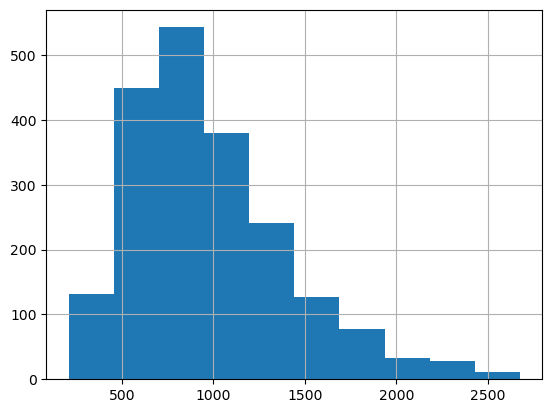

In [15]:
df_longt5.candidate.str.len().hist()

In [21]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_longt5)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_longt5, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.3689880935169033, recall=0.1373716882683111, fmeasure=0.18146408062581565), mid=Score(precision=0.37411828801996916, recall=0.1409145648626524, fmeasure=0.18470632255173647), high=Score(precision=0.3794242086017666, recall=0.14449596274682863, fmeasure=0.1879584466757623)),
  'rouge2': AggregateScore(low=Score(precision=0.04557487872639194, recall=0.01590814686224898, fmeasure=0.021231856485365564), mid=Score(precision=0.04793996144557606, recall=0.016668281522408682, fmeasure=0.0221177594000776), high=Score(precision=0.050202056518269936, recall=0.017373962287074943, fmeasure=0.022961333533190822)),
  'rougeL': AggregateScore(low=Score(precision=0.21965267778396885, recall=0.07783630907778631, fmeasure=0.10407646651699773), mid=Score(precision=0.22360079833164628, recall=0.07955625729090238, fmeasure=0.105555116591603), high=Score(precision=0.22757073587894702, recall=0.08141784681695725, fmeasure=0.10705688532393431)),
  'roug

Computing BERTscore...


{'bertscore_avg_p': 0.511027991771698,
 'bertscore_avg_r': 0.5844007730484009,
 'bertscore_avg_f': 0.5434643030166626,
 'bertscore_std_p': 0.04310934618115425,
 'bertscore_std_r': 0.048223260790109634,
 'bertscore_std_f': 0.033570773899555206}

In [80]:
# Do the same for Pegasus

df_pegasus = pd.read_csv("PEGASUS_LARGE/val-prediction.csv", index_col=0).reset_index(drop=True)
df_pegasus.rename(columns={"Summary": "candidate"}, inplace=True)
df_pegasus['review_id'] = df_pegasus['review_id'].astype(str)
display(df_pegasus.head())

# organize into dicts for rouge and bertscore
generated_pegasus = {row['review_id']: row['candidate'] for _, row in df_pegasus.iterrows()}
# check to see if all docids are present and unique
assert set(generated_pegasus.keys()) == set(targets.keys())
assert len(generated_pegasus) == len(targets)

,review_id,candidate
0,28514886,The 5′ nuclease assays were subsequently used ...
1,18842808,GM fibers reduced total cholesterol ( TC ) con...
2,24297836,The purpose of this study was 1 ) to evaluate ...
3,32367221,"Pain on kneeling, KT-1000 measured side to sid..."
4,25038833,RESULTS Results of the Name-Face Association T...


<Axes: >

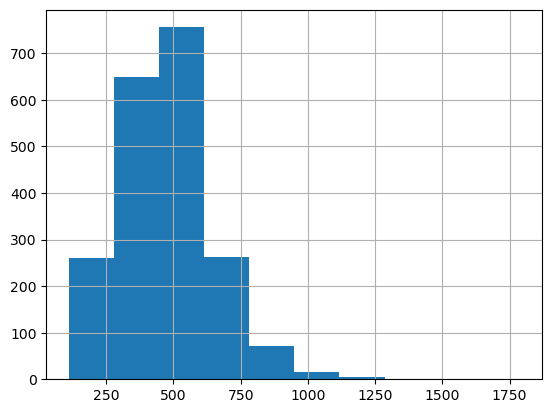

In [30]:
df_pegasus.candidate.str.len().hist()

In [31]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_pegasus)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_pegasus, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.23188510954639052, recall=0.16099073832364824, fmeasure=0.17069165533548553), mid=Score(precision=0.23636549568618445, recall=0.16508845641785155, fmeasure=0.17369981891498523), high=Score(precision=0.2410069773924332, recall=0.16849743182924395, fmeasure=0.17653612736981214)),
  'rouge2': AggregateScore(low=Score(precision=0.025609972888597017, recall=0.016841790228365836, fmeasure=0.018114094286240737), mid=Score(precision=0.027286249022990428, recall=0.01787230488805157, fmeasure=0.01910065539440901), high=Score(precision=0.028971208429477726, recall=0.01883083674581007, fmeasure=0.020115374285278053)),
  'rougeL': AggregateScore(low=Score(precision=0.14984277944496277, recall=0.10096691095688277, fmeasure=0.10783642394171626), mid=Score(precision=0.1529523009446699, recall=0.10302738727799489, fmeasure=0.10937489929608912), high=Score(precision=0.15617329592365214, recall=0.10519244319098883, fmeasure=0.11108952315261846)),


Computing BERTscore...


{'bertscore_avg_p': 0.4978368282318115,
 'bertscore_avg_r': 0.5536131858825684,
 'bertscore_avg_f': 0.5221330523490906,
 'bertscore_std_p': 0.05015239864587784,
 'bertscore_std_r': 0.057531993836164474,
 'bertscore_std_f': 0.042330335825681686}

## Delta Evidence Inference

In [10]:
# Run this once to get EI model params
!cd evaluator/ && wget https://ai2-s2-ms2.s3-us-west-2.amazonaws.com/evidence_inference_models.zip  # For Linux
# !cd evaluator/ && curl -O https://ai2-s2-ms2.s3-us-west-2.amazonaws.com/evidence_inference_models.zip  # For MacOS if there's no wget
!cd evaluator/ && unzip -q evidence_inference_models.zip

In [75]:
# Delta Evidence Inference
# From MSLR repo
import os
import json
import torch
from typing import Dict
from importlib import reload
import random

from evaluator import evaluator


# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# also consider mps
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(0)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')


def calculate_evidence_inference_divergence(
        targets: Dict[str, Dict],
        generated: Dict[str, str],
        ei_param_file: str,
        ei_model_dir: str,
        ei_use_unconditional: bool = False
) -> Dict:
    """
    Calculate Evidence Inference Divergence
    :param targets: dict of docid -> {'target': target_text , 'preface': preface_text}
    :param generated: dict of docid -> generated_text
    :param ei_param_file: path to json file containing EI model parameters
    :param ei_model_dir:
    :param ei_use_unconditional:
    :return:
    """
    print("Computing Delta Evidence Inference scores...")
    docids = list(targets.keys())
    target_texts = [targets[docid]['target'] for docid in docids]
    preface_texts = [targets[docid]['preface'] for docid in docids]
    generated_texts = [generated.get(docid, '') for docid in docids]

    generated_texts = list(map(evaluator.clean, generated_texts))
    target_texts = list(map(evaluator.clean, target_texts))

    # evidence inference scoring
    with open(ei_param_file, 'r') as inf:
        params = json.loads(inf.read())
    _, evidence_inference_classifier, _, _, _, evidence_inference_tokenizer = evaluator.initialize_models(params)
    if ei_use_unconditional:
        classifier_file = os.path.join(
            ei_model_dir,
            'unconditioned_evidence_classifier',
            'unconditioned_evidence_classifier.pt'
        )
    else:
        classifier_file = os.path.join(
            ei_model_dir, 'evidence_classifier', 'evidence_classifier.pt'
        )

    # pooler parameters are added by default in an older transformers, so we have to ignore that those are uninitialized.
    evidence_inference_classifier.load_state_dict(
        torch.load(classifier_file, map_location=device), strict=False
    )
    if torch.cuda.is_available():
        evidence_inference_classifier.cuda()
    elif torch.backends.mps.is_available():
        evidence_inference_classifier.to(device)

    entailment_results = evaluator.entailment_scores(
        evidence_inference_classifier, evidence_inference_tokenizer,
        generated_texts, target_texts, preface_texts,
        use_ios=ei_use_unconditional
    )

    return entailment_results

In [77]:
# Test usage on toy examples
reload(evaluator)

some_targets = ["significant improvements are found", "treatment is definitely not helpful", "no significant results are found"]
a_generic_preface = "studying this is important"

# modify targets_toy to include preface (key "background", value "this is a test")
num_examples = 10

targets_toy_2 = {
    doc_key: {
        "target": random.choice(some_targets),
        "preface": a_generic_preface,
    } for doc_key in range(num_examples)
}
generated_toy_2 = {
    doc_key: random.choice(some_targets) for doc_key in range(num_examples)
}

# test usage
results_toy = calculate_evidence_inference_divergence(
    targets_toy_2,
    generated_toy_2,
    "evaluator/bert_pipeline_8samples.json",
    "evaluator/evidence_inference_models",
)
# print everything except the raw scores
for key, val in results_toy.items():
    if key != "scores":
        display(key, val)

# Compare scores and target-generated pairs in a dataframe
df_toy = pd.DataFrame({
    "docid": list(targets_toy_2.keys()),
    "target": [targets_toy_2[docid]["target"] for docid in targets_toy_2.keys()],
    "generated": [generated_toy_2[docid] for docid in generated_toy_2.keys()],
    "score": list(results_toy["scores"]),
})
display(df_toy)

Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'average'

0.19373307094613526

'std'

0.30078610414331475

'uniform_preds'

0.46051702656047766

'f1_score'

{'significantly decreased': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 0.0},
 'no significant difference': {'precision': 0.8888888888888888,
  'recall': 1.0,
  'f1-score': 0.9411764705882353,
  'support': 8.0},
 'significantly increased': {'precision': 1.0,
  'recall': 0.5,
  'f1-score': 0.6666666666666666,
  'support': 2.0},
 'micro avg': {'precision': 0.9,
  'recall': 0.9,
  'f1-score': 0.9,
  'support': 10.0},
 'macro avg': {'precision': 0.6296296296296297,
  'recall': 0.5,
  'f1-score': 0.5359477124183006,
  'support': 10.0},
 'weighted avg': {'precision': 0.9111111111111111,
  'recall': 0.9,
  'f1-score': 0.8862745098039216,
  'support': 10.0}}

,docid,target,generated,score
0,0,no significant results are found,no significant results are found,0.000000
1,1,treatment is definitely not helpful,no significant results are found,0.315579
2,2,treatment is definitely not helpful,treatment is definitely not helpful,0.000000
3,3,treatment is definitely not helpful,no significant results are found,0.315579
4,4,no significant results are found,no significant results are found,0.000000
5,5,significant improvements are found,significant improvements are found,0.000000
6,6,treatment is definitely not helpful,no significant results are found,0.315579
7,7,significant improvements are found,no significant results are found,0.990595
8,8,treatment is definitely not helpful,treatment is definitely not helpful,0.000000
9,9,treatment is definitely not helpful,treatment is definitely not helpful,0.000000


In [78]:
# Test on X sample docs
generated_candidates_to_use = generated_longt5
# num_examples = 100
num_examples = len(generated_candidates_to_use)  # to get all examples

targets_x_sample = {
    doc_key: {
        "target": targets[doc_key]["target"],
        "preface": targets[doc_key]["background"],
    } for doc_key in list(targets.keys())[:num_examples]
}
generated_x_sample = {
    doc_key: generated_candidates_to_use[doc_key] for doc_key in targets_x_sample.keys()
}
results_x_sample = calculate_evidence_inference_divergence(
    targets_x_sample,
    generated_x_sample,
    "evaluator/bert_pipeline_8samples.json",
    "evaluator/evidence_inference_models",
)

# print everything except the raw scores
for key, val in results_x_sample.items():
    if key != "scores":
        display(key, val)

# Compare scores and target-generated pairs in a dataframe
df_x_sample = pd.DataFrame({
    "docid": list(targets_x_sample.keys()),
    "target": [targets_x_sample[docid]["target"] for docid in targets_x_sample.keys()],
    "generated": [generated_x_sample[docid] for docid in generated_x_sample.keys()],
    "score": list(results_x_sample["scores"]),
})
display(df_x_sample.sample(10))

# save results to csv
df_x_sample.to_csv("evaluator/evidence_inference_results_longt5.csv", index=False)

Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


'average'

0.5432441385412898

'std'

0.39463136145671507

'uniform_preds'

0.5406478590360975

'f1_score'

{'significantly decreased': {'precision': 0.09401709401709402,
  'recall': 0.1981981981981982,
  'f1-score': 0.127536231884058,
  'support': 111.0},
 'no significant difference': {'precision': 0.639599555061179,
  'recall': 0.47364085667215816,
  'f1-score': 0.5442498816848084,
  'support': 1214.0},
 'significantly increased': {'precision': 0.375,
  'recall': 0.47844827586206895,
  'f1-score': 0.42045454545454547,
  'support': 696.0},
 'accuracy': 0.46016823354774866,
 'macro avg': {'precision': 0.369538883026091,
  'recall': 0.3834291102441418,
  'f1-score': 0.3640802196744706,
  'support': 2021.0},
 'weighted avg': {'precision': 0.518510518198995,
  'recall': 0.46016823354774866,
  'f1-score': 0.4787294615244193,
  'support': 2021.0}}

,docid,target,generated,score
1376,28668150,( S ) Few studies of medical therapies for end...,"In this study, the effects of continuous or cy...",0.019503
15,28616252,Our case study successfully enabled us to addr...,"This paper focuses on pilot studies, or ""feasi...",0.504117
329,30921478,Two primary outcomes of efficacy and acceptabi...,A double blind trial of a combination of alpra...,0.006196
76,10796152,REVIEW ER 'S CONCLUSIONS Iodine supplementatio...,"In this study, the effects of reduced maternal...",0.485056
77,26897342,"Among children , these interventions demonstra...","The Switch program is a novel, evidence-based ...",0.983839
727,28898559,"Physical activity did not change at 6 months ,...","In this study, we examine the efficacy of a lo...",0.846085
515,29279934,Subgroup analyses showed that these results we...,This study focuses on the effects of four-mont...,0.110708
979,30985692,Results : This systematic review will provide ...,"In this study, the combined efficaciousness of...",0.452037
1760,26081915,The findings support the effects of BAs on sat...,Gastric bypass is an effective treatment for T...,0.983107
1549,25978537,Reflecting public health interest in the poten...,"In this study, we examine the effects of a six...",0.088469


In [74]:
import pprint

# What's actually happening?
# find the docid with the highest score
print("Highest score: (higher is bad)")
pprint.pprint(df_x_sample.sort_values(by="score", ascending=False).head(1).to_dict(orient="records"))

# find the docid with the lowest score
print("Lowest score: (lower is good)")
pprint.pprint(df_x_sample.sort_values(by="score", ascending=True).head(1).to_dict(orient="records"))

Highest score: (higher is bad)
[{'docid': '25076495',
  'generated': "The Nurses' Health Study, a large cohort study of women aged "
               '52-77 years, records the consumption of walnuts in relation to '
               'risk of type two diabetes. In this paper, we report that there '
               'is a significant lower risk of Type 2 disease in women who '
               'consume more than 1 serving per day. Women who do not '
               'frequently consume walnuts are also associated with an '
               'increased risk of developing type 2 disease. We conclude that '
               'higher nuts have a protective effect on both blood lipid and '
               'body weight because they improve insulin sensitivity. A diet '
               'rich in fat but low in carbohydrates has been shown to be '
               'effective in improving many modifiably important '
               'cardiovascular risk factors. Almond was found to be superior '
               'to othe

In [83]:
# Wrap in a loop

model_results = {}
for model_name, generated_candidates_to_use in [
    ("BioBART", generated_biobart),
    ("LongT5", generated_longt5),
    ("Pegasus", generated_pegasus),
]:
    print(f"\n\n##### Running {model_name} #####")
    num_examples = len(generated_candidates_to_use)  # to get all examples

    targets_x_sample = {
        doc_key: {
            "target": targets[doc_key]["target"],
            "preface": targets[doc_key]["background"],
        } for doc_key in list(targets.keys())[:num_examples]
    }
    generated_x_sample = {
        doc_key: generated_candidates_to_use[doc_key] for doc_key in targets_x_sample.keys()
    }
    results_x_sample = calculate_evidence_inference_divergence(
        targets_x_sample,
        generated_x_sample,
        "evaluator/bert_pipeline_8samples.json",
        "evaluator/evidence_inference_models",
    )
    model_results[model_name] = {}
    model_results[model_name]["results"] = results_x_sample

    # print everything except the raw scores
    for key, val in results_x_sample.items():
        if key != "scores":
            display(key, val)

    # Compare scores and target-generated pairs in a dataframe
    df_x_sample = pd.DataFrame({
        "docid": list(targets_x_sample.keys()),
        "target": [targets_x_sample[docid]["target"] for docid in targets_x_sample.keys()],
        "generated": [generated_x_sample[docid] for docid in generated_x_sample.keys()],
        "score": list(results_x_sample["scores"]),
    })
    model_results[model_name]["df"] = df_x_sample
    display(df_x_sample.sample(10))

    # save results to csv
    df_x_sample.to_csv(f"evaluator/evidence_inference_results_{model_name.lower()}.csv", index=False)



##### Running BioBART #####
Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
